# Hand Tracking Model

## Load imports

In [114]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import mediapipe as mp
import os
import cv2
from hand_tracking import extract_landmarks, normalization
RANDOM_SEED = 41

## Load file paths

In [115]:
dataset = 'landmark_data/landmarks_data.csv'

dataset_open = 'landmark_data/gesture_open'
dataset_close = 'landmark_data/gesture_close'

model_save_path = 'model_save/hand_tracking_model.keras'
hdf5_save_path = 'model_save/hand_tracking_model.hdf5'

tflite_save_path = 'model_save/hand_tracking_model.tflite'

## Number of classes

In [116]:
NUM_CLASSES = 2

## Dataset reading
Load:
* X_dataset - coordinates of landmarks
* Y_dataset_str - labels of gesture with string labels

### Text dataset (only if needed)

In [117]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)), skiprows=1)

In [118]:
Y_dataset_str = np.loadtxt(dataset, delimiter=',', dtype='str', usecols=(0), skiprows=1)

### Divide photo registration and point extraction

#### Extract function
<code>extract_landmarks_second(image, hand)</code> accept only (42,) array of landmarks
* If it is less than 42, it will be padded with zeros
* If it is more than 42, it will be cut to 42

In [119]:
def extract_landmarks_second(image, hand):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    result = hand.process(image_rgb)

    landmarks = []

    if result.multi_hand_landmarks:
        for hand_landmarks in result.multi_hand_landmarks:
            for lm in hand_landmarks.landmark:
                h, w, _ = image.shape
                cx, cy = int(lm.x * w), int(lm.y * h)
                landmarks.extend([cx, cy])
    landmarks = np.array(landmarks)
    if len(landmarks) < 42:
        landmarks = np.pad(landmarks, (0, 42 - len(landmarks)), 'constant')
    elif len(landmarks) > 42:
        landmarks = landmarks[:42]
    return landmarks

#### Extract landmarks

In [120]:
# Define the folders
open_folder = 'landmark_data/gesture_open'
close_folder = 'landmark_data/gesture_close'

open_images = []
close_images = []

landmarks = []
labels = []

mp_hands = mp.solutions.hands
hand = mp_hands.Hands()
for image in os.listdir(open_folder):
    image_path = os.path.join(open_folder, image)
    img = cv2.imread(image_path)
    landmark = extract_landmarks_second(img, hand)
    landmarks.append(landmark.tolist())
    labels.append("OPEN")
        
for image in os.listdir(close_folder):
    image_path = os.path.join(close_folder, image)
    img = cv2.imread(image_path)
    landmark = extract_landmarks_second(img, hand)
    landmarks.append(landmark.tolist())
    labels.append("CLOSE")

Copy to the dataset

In [121]:
X_dataset = np.array(landmarks)
Y_dataset_str = np.array(labels)

Checking some samples:

In [122]:
print("First 5 rows of dataset X:")
print(X_dataset[:5])

print("First 5 rows of dataset Y:")
print(Y_dataset_str[:5])

First 5 rows of dataset X:
[[632. 509. 670. 488. 699. 454. 724. 418. 755. 393. 684. 373. 695. 321.
  694. 285. 693. 255. 656. 368. 659. 311. 656. 273. 653. 239. 629. 375.
  624. 323. 618. 290. 614. 261. 603. 393. 581. 356. 566. 331. 555. 306.]
 [634. 511. 669. 488. 698. 452. 723. 417. 753. 394. 684. 371. 694. 319.
  695. 283. 694. 252. 656. 366. 659. 309. 654. 272. 649. 240. 630. 374.
  624. 324. 618. 290. 613. 262. 602. 392. 581. 357. 567. 332. 557. 307.]
 [672. 521. 718. 488. 746. 437. 767. 398. 795. 374. 692. 371. 695. 319.
  697. 285. 697. 255. 658. 372. 650. 315. 645. 278. 640. 246. 628. 386.
  612. 334. 604. 301. 599. 271. 602. 412. 577. 376. 562. 352. 552. 327.]
 [567. 384. 630. 344. 671. 282. 701. 227. 729. 187. 613. 206. 626. 135.
  630.  90. 630.  49. 568. 202. 565. 124. 561.  73. 555.  29. 526. 216.
  514. 141. 508.  93. 502.  52. 487. 242. 455. 186. 434. 147. 417. 109.]
 [550. 393. 609. 352. 651. 285. 681. 229. 712. 188. 593. 207. 605. 136.
  608.  89. 607.  46. 548. 204. 5

In [123]:
# Check unique values of Y dataset
print("Label set unique values: ", list(np.unique(Y_dataset_str)))

Label set unique values:  ['CLOSE', 'OPEN']


In [124]:
# Set label encoder to the Y dataset
label_encoder = LabelEncoder()
Y_dataset = label_encoder.fit_transform(Y_dataset_str)

print("Label set unique values: ", list(np.unique(Y_dataset)))

Label set unique values:  [0, 1]


## Data normalization

In [125]:
def normalization(dataset):
    mean_x = np.mean(dataset[:, ::2], axis=1)
    mean_y = np.mean(dataset[:, 1::2], axis=1)
    
    normalized_dataset = np.zeros_like(dataset)
    
    for i in range(dataset.shape[0]):
        normalized_dataset[i, ::2] = dataset[i, ::2] - mean_x[i]
        normalized_dataset[i, 1::2] = dataset[i, 1::2] - mean_y[i]
    return normalized_dataset

In [126]:
normalized_X_dataset = normalization(X_dataset)
X_train, X_test, Y_train, Y_test = train_test_split(normalized_X_dataset, Y_dataset, test_size=0.75, random_state=RANDOM_SEED)

## Model

In [127]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.15),

    tf.keras.layers.Dense(21, activation='relu'),
    tf.keras.layers.Dropout(0.15),
    
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dropout(0.1),

    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [128]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_6 (Dropout)             │ (None, 42)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 21)             │           903 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 21)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │           220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 4)              │            44 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │            10 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,177 (4.60 KB)

 Trainable params: 1,177 (4.60 KB)

 Non-trainable params: 0 (0.00 B)

In [129]:
checkpoints_callback = tf.keras.callbacks.ModelCheckpoint(model_save_path, verbose=0, save_weights_only=False)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=0)

In [130]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [131]:
model.fit(
    X_train,
    Y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, Y_test),
    callbacks=[checkpoints_callback, early_stopping_callback],
    verbose=0
)

In [132]:
val_loss, val_acc = model.evaluate(X_test, Y_test, batch_size=128)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0097 


In [133]:
model = tf.keras.models.load_model(model_save_path)

predict_result = model.predict(np.array([X_test[0]]))

print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
[9.9968040e-01 3.1963424e-04]
0


## Confusion matrix

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step


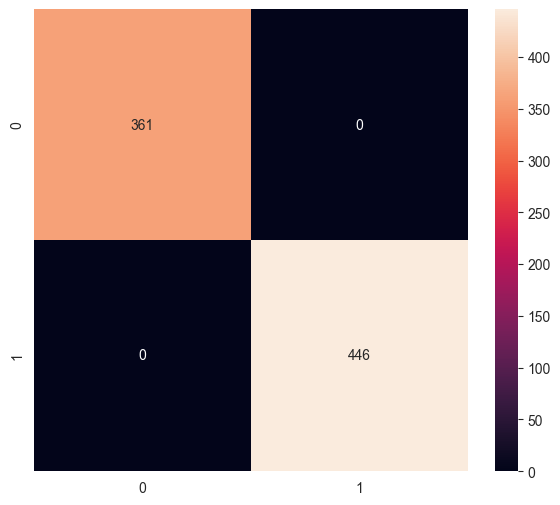

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       361
           1       1.00      1.00      1.00       446

    accuracy                           1.00       807
   macro avg       1.00      1.00      1.00       807
weighted avg       1.00      1.00      1.00       807


In [134]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(Y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(Y_test, y_pred)

## Testing

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


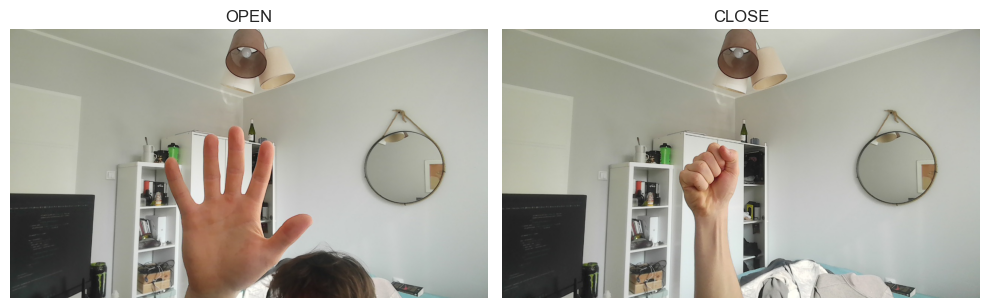

In [135]:
import mediapipe as mp
import cv2
import matplotlib.pyplot as plt
import random
import os
from hand_tracking import extract_landmarks
model_to_test = tf.keras.models.load_model('model_save/hand_tracking_model.keras')



open_folder = 'landmark_data/gesture_open'
close_folder = 'landmark_data/gesture_close'


def normalization(landmarks):
    landmarks = np.reshape(landmarks, (1, -1))  # Zamienia tablicę 1x42 na 21x2
    mean_x = np.mean(landmarks[:, ::2], dtype=float)  # Średnia dla pierwszej kolumny
    mean_y = np.mean(landmarks[:, 1::2], dtype=float)  # Średnia dla drugiej kolumny
    
    normalized_landmarks = np.zeros_like(landmarks, dtype=float)
    
    normalized_landmarks[:, ::2] = landmarks[:, ::2] - mean_x
    normalized_landmarks[:, 1::2] = landmarks[:, 1::2] - mean_y
    
    return np.reshape(normalized_landmarks, (1, -1))
    
def predict(image):
    mp_hands = mp.solutions.hands
    hand = mp_hands.Hands()
    
    landmarks = extract_landmarks(image, hand)
    landmarks = normalization(landmarks)
    
    prediction = model.predict(landmarks)
    hand_state = np.argmax(prediction)
    if hand_state == 0:
        return "CLOSE", image
    else:
        return "OPEN", image

def prepare_test(rows):
    images = []
    titles = []
    for _ in range(rows):
        image_index = random.randint(0, len(os.listdir(open_folder))-150)
        image = cv2.imread(os.path.join(open_folder, f"o_{image_index}.jpg"))
        images.append(image)
        titles.append(predict(image)[0])
    for _ in range(rows):
        image_index = random.randint(0, len(os.listdir(close_folder))-150)
        image = cv2.imread(os.path.join(close_folder, f"c_{image_index}.jpg"))
        images.append(image)
        titles.append(predict(image)[0])
    return images, titles

def display_test(rows):
    fig, axs = plt.subplots(rows, 2, figsize=(10, 8))
    images, titles = prepare_test(rows)
    
    for i, ax in enumerate(axs.flat):
        ax.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        ax.set_title(titles[i])
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
display_test(1)